In [23]:
import pandas as pd
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [82]:
bookings_raw = pd.read_csv("../data/raw/booking_log.csv")
experiments_raw = pd.read_csv("../data/raw/experiment_log.csv")
participants_raw = pd.read_csv("../data/raw/participant_log.csv")
test = pd.read_csv("../data/raw/test_data.csv")

In [83]:
bookings_raw[bookings_raw["order_id"]==100004630900]

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
150993,2015-05-12 00:21:29.932 UTC,100004630900,CREATED,407518871636,NaN,1.006,-2.961099,104.783248
309969,2015-05-12 00:27:09.097 UTC,100004630900,COMPLETED,407518871636,5.760948e+11,1.006,-2.961099,104.783248
462311,2015-05-12 00:23:40.628 UTC,100004630900,PICKED_UP,407518871636,5.760948e+11,1.006,-2.961099,104.783248
633198,2015-05-12 00:21:30.885 UTC,100004630900,DRIVER_FOUND,407518871636,5.760948e+11,1.006,-2.961099,104.783248


In [7]:
participants_raw[participants_raw["order_id"]==100004630900]


,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
67603,2015-05-12 00:21:30.198 UTC,576094811632,CREATED,100004630900,729783043745,-2.960315,104.783728,7.0
67604,2015-05-12 00:21:30.83 UTC,576094811632,ACCEPTED,100004630900,729783043745,-2.960315,104.783728,7.0


In [33]:
# Booking conversion rate
print (bookings_raw.dtypes)

event_timestamp      object
order_id              int64
booking_status       object
customer_id           int64
driver_id           float64
trip_distance       float64
pickup_latitude     float64
pickup_longitude    float64
dtype: object


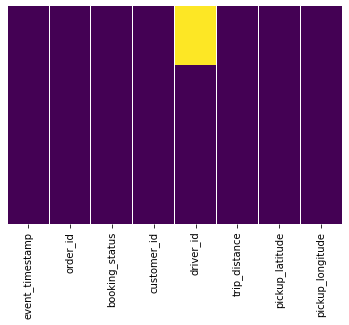

In [84]:
sns.heatmap(bookings_raw.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

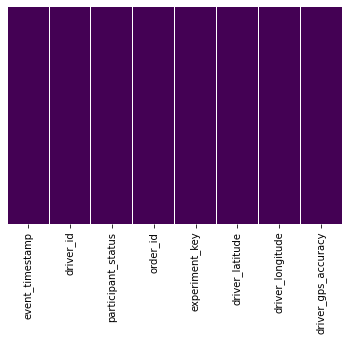

In [25]:
sns.heatmap(participants_raw.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [85]:
print ('--bookings_null_values--')

print (bookings_raw.isnull().sum()) 

print ('--participants_null_values--')

print (participants_raw.isnull().sum())


--bookings_null_values--
event_timestamp         92
order_id                 0
booking_status           0
customer_id              0
driver_id           193710
trip_distance            0
pickup_latitude          0
pickup_longitude         0
dtype: int64
--participants_null_values--
event_timestamp        0
driver_id              0
participant_status     0
order_id               0
experiment_key         0
driver_latitude        0
driver_longitude       0
driver_gps_accuracy    0
dtype: int64


In [86]:
bookings_raw[bookings_raw["event_timestamp"].isnull()]["booking_status"].unique()


array(['DRIVER_CANCELLED', 'CUSTOMER_CANCELLED'], dtype=object)

In [87]:
bookings_raw['booking_status'].unique()

array(['DRIVER_NOT_FOUND', 'DRIVER_CANCELLED', 'CREATED', 'COMPLETED',
       'PICKED_UP', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED'], dtype=object)

# Bookings exploratory

In [88]:
bookings_raw[["day", "time", "utc"]] = bookings_raw.event_timestamp.str.split(expand=True)
bookings_raw.drop(["utc"], axis = 1, inplace = True)
bookings_raw["timestamp"] = bookings_raw[["day", "time"]].astype(str).apply(lambda x: ' '.join(x), axis = 1)
bookings_raw["timestamp"] = pd.to_datetime(bookings_raw["timestamp"], errors = 'coerce')
bookings_raw = bookings_raw[bookings_raw['timestamp'].notnull()]


In [45]:
def _compute_freq_cluster(df):
    group_freq = '60min'
    df['pickup_datetime_group'] = df['timestamp'].dt.round(group_freq)
    return df

In [56]:
def temporal_features(df):
    df['weekday'] = df['timestamp'].dt.weekday
    df['hour_weekofyear'] = df['timestamp'].dt.weekofyear
    df['chour'] = df['timestamp'].dt.hour
    return df

In [57]:
bookings_raw = _compute_freq_cluster(bookings_raw)
bookings_raw = temporal_features(bookings_raw)

In [49]:
print (bookings_raw['timestamp'].max()) 
print (bookings_raw['timestamp'].min())

2015-05-19 00:18:25.721540
2015-05-10 00:00:06.456000


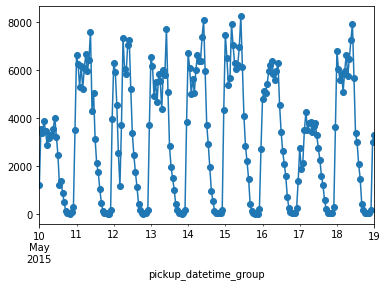

In [47]:
bookings_raw.groupby('pickup_datetime_group').count().unstack()['order_id'].plot(kind = 'line', marker = 'o')

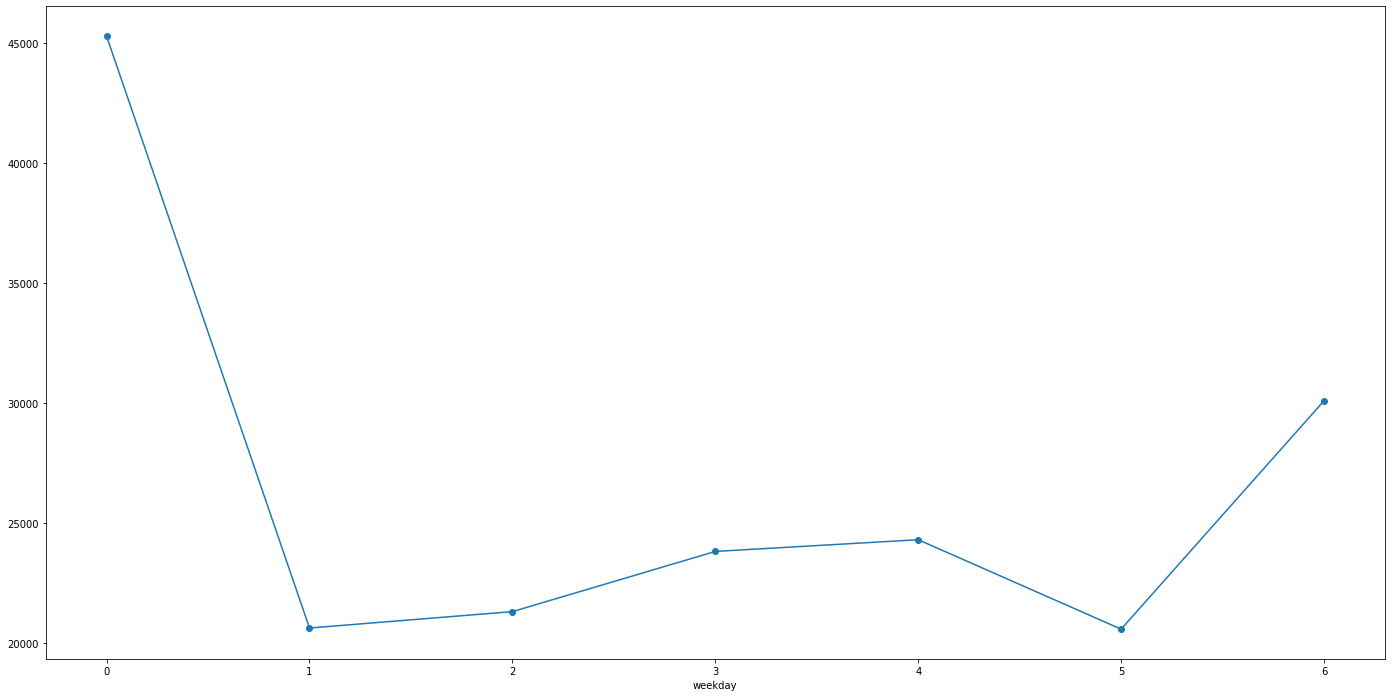

In [67]:
fig, ax = plt.subplots(figsize=(24, 12))

bookings_raw[bookings_raw['booking_status'] == 'CREATED']\
.groupby('weekday').count().unstack()['order_id'].plot(kind = 'line', ax=ax, marker = 'o')

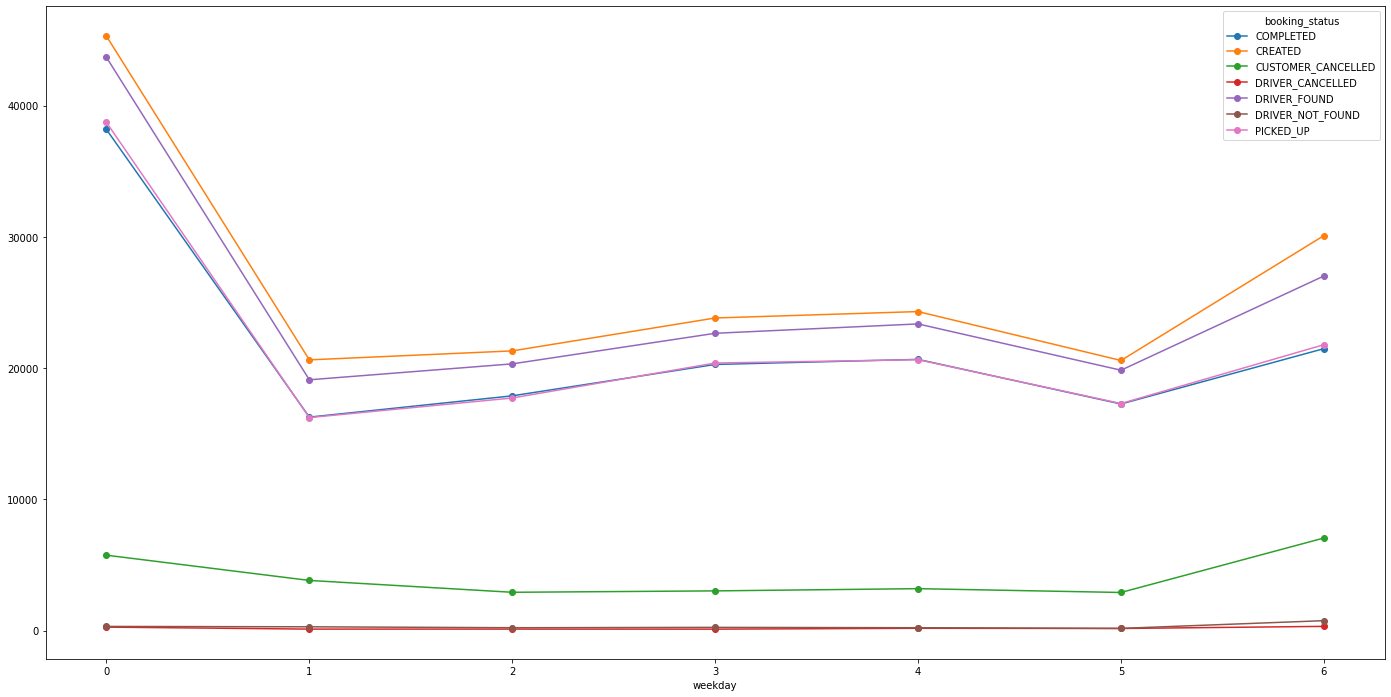

In [69]:
fig, ax = plt.subplots(figsize=(24, 12))

bookings_raw.groupby(['weekday', 'booking_status']).count().unstack()['order_id'].plot(kind = 'line', ax=ax, marker = 'o')

In [37]:
data = bookings_raw[bookings_raw['booking_status'] == 'DRIVER_CANCELLED']

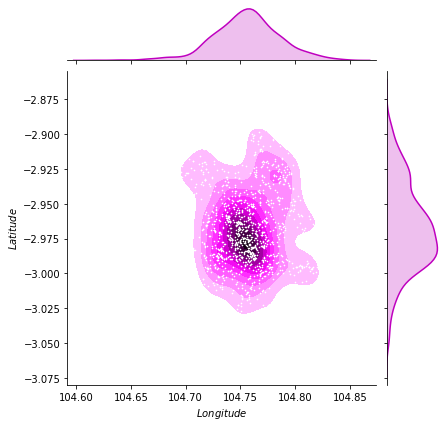

In [38]:
g = sns.jointplot(x="pickup_longitude", y="pickup_latitude", data=data, kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=3, linewidth=0.5, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Longitude$", "$Latitude$");
plt.show()

In [70]:
experiment_tag_dict = dict(zip(experiments_raw.order_id, experiments_raw.experiment_tag))

In [71]:
participants_raw['experiment_tag'] = participants_raw['order_id'].map(experiment_tag_dict)

In [72]:
participants_raw.head()

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,experiment_tag
0,2015-05-18 11:45:19.519 UTC,110283102582,CREATED,938125906616,309579604593,-2.981389,104.761898,2.0,B
1,2015-05-18 11:45:29.8 UTC,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.0,B
2,2015-05-11 10:35:57.021 UTC,126346998414,CREATED,992080359113,941995970460,-2.966915,104.748040,2.0,A
3,2015-05-11 10:36:01.148 UTC,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.0,A
4,2015-05-16 12:34:20.044 UTC,199325048812,ACCEPTED,797723880713,197604093364,-3.014740,104.694647,2.0,B


# Data Cleaning

In [89]:
list_of_booking_status = []
for x, y in bookings_raw.groupby("order_id"):
    list_of_booking_status.append(y['booking_status'].values)

In [90]:
combinations_ = [list(i) for i in set(tuple(i) for i in list_of_booking_status)]

In [91]:
combinations_

[['DRIVER_CANCELLED', 'CREATED', 'PICKED_UP', 'DRIVER_FOUND'],
 ['CUSTOMER_CANCELLED'],
 ['CREATED', 'CUSTOMER_CANCELLED'],
 ['CREATED', 'COMPLETED', 'DRIVER_FOUND'],
 ['DRIVER_CANCELLED'],
 ['CREATED', 'PICKED_UP', 'DRIVER_FOUND'],
 ['DRIVER_NOT_FOUND', 'CREATED'],
 ['CREATED', 'PICKED_UP', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED'],
 ['CREATED', 'DRIVER_FOUND'],
 ['CREATED', 'COMPLETED'],
 ['CREATED'],
 ['DRIVER_CANCELLED', 'CREATED', 'DRIVER_FOUND'],
 ['CREATED', 'COMPLETED', 'COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'],
 ['CREATED', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED'],
 ['PICKED_UP', 'CUSTOMER_CANCELLED'],
 ['COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'],
 ['CREATED', 'COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'],
 ['DRIVER_CANCELLED', 'PICKED_UP']]

In [92]:
from collections import Counter
count = Counter(map(tuple, list_of_booking_status))


In [202]:
dict(count)


{('COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'): 1,
 ('CREATED',): 134,
 ('CREATED', 'COMPLETED'): 1951,
 ('CREATED', 'COMPLETED', 'DRIVER_FOUND'): 14683,
 ('CREATED', 'COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'): 135396,
 ('CREATED', 'CUSTOMER_CANCELLED'): 5736,
 ('CREATED', 'DRIVER_FOUND'): 1074,
 ('CREATED', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED'): 6974,
 ('CREATED', 'PICKED_UP', 'DRIVER_FOUND'): 259,
 ('CREATED', 'PICKED_UP', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED'): 15938,
 ('CUSTOMER_CANCELLED',): 92,
 ('DRIVER_CANCELLED',): 6,
 ('DRIVER_CANCELLED', 'CREATED', 'DRIVER_FOUND'): 463,
 ('DRIVER_CANCELLED', 'CREATED', 'PICKED_UP', 'DRIVER_FOUND'): 841,
 ('DRIVER_CANCELLED', 'PICKED_UP'): 4,
 ('DRIVER_NOT_FOUND', 'CREATED'): 2262,
 ('PICKED_UP', 'CUSTOMER_CANCELLED'): 53}

In [93]:
error_booking_status = {('DRIVER_CANCELLED', 'PICKED_UP'): 4,
                        ('COMPLETED', 'PICKED_UP', 'DRIVER_FOUND'): 1,
                        ('CREATED', 'DRIVER_FOUND'): 1074,
                        ('PICKED_UP', 'CUSTOMER_CANCELLED'): 53,
                        ('CREATED', 'COMPLETED'): 1951,
                        ('CREATED',): 134,
                        ('CREATED', 'COMPLETED', 'DRIVER_FOUND'): 14683,
                        ('CREATED', 'PICKED_UP', 'DRIVER_FOUND'): 259,
                        ('DRIVER_CANCELLED',): 6,
                        ('DRIVER_CANCELLED', 'CREATED', 'PICKED_UP', 'DRIVER_FOUND'): 841,
                        ('DRIVER_CANCELLED', 'PICKED_UP'): 4,
                        ('CUSTOMER_CANCELLED',): 92,
                       }
                              

In [94]:
for key, value in count.items():
    if key not in error_booking_status.keys():
        print (key)

('CREATED', 'COMPLETED', 'PICKED_UP', 'DRIVER_FOUND')
('CREATED', 'CUSTOMER_CANCELLED')
('CREATED', 'PICKED_UP', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED')
('CREATED', 'DRIVER_FOUND', 'CUSTOMER_CANCELLED')
('DRIVER_NOT_FOUND', 'CREATED')
('DRIVER_CANCELLED', 'CREATED', 'DRIVER_FOUND')
('CREATED', 'COMPLETED', 'COMPLETED', 'PICKED_UP', 'DRIVER_FOUND')


In [340]:
len(participants_raw.driver_id.unique())


14913

In [353]:
bookings_raw[bookings_raw["order_id"]==100004630900]

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude,day,time,timestamp,diff
151243,2015-05-12 00:21:29.932 UTC,100004630900,CREATED,407518871636,NaN,1.006,-2.961099,104.783248,2015-05-12,00:21:29.932,2015-05-12 00:21:29.932,NaT
310294,2015-05-12 00:27:09.097 UTC,100004630900,COMPLETED,407518871636,5.760948e+11,1.006,-2.961099,104.783248,2015-05-12,00:27:09.097,2015-05-12 00:27:09.097,00:03:28.469000
462877,2015-05-12 00:23:40.628 UTC,100004630900,PICKED_UP,407518871636,5.760948e+11,1.006,-2.961099,104.783248,2015-05-12,00:23:40.628,2015-05-12 00:23:40.628,00:02:09.743000
634106,2015-05-12 00:21:30.885 UTC,100004630900,DRIVER_FOUND,407518871636,5.760948e+11,1.006,-2.961099,104.783248,2015-05-12,00:21:30.885,2015-05-12 00:21:30.885,00:00:00.953000


In [95]:
merge_columns = ["driver_id", "driver_latitude", "driver_longitude"]
participants_raw[participants_raw['participant_status'] == "ACCEPTED"].merge(bookings_raw, on = "order_id")

,event_timestamp_x,driver_id_x,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp_y,booking_status,customer_id,driver_id_y,trip_distance,pickup_latitude,pickup_longitude,day,time,timestamp
0,2015-05-18 11:45:29.8 UTC,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.000,2015-05-18 11:45:03.958 UTC,CREATED,786955815516,NaN,5.601,-2.980337,104.761200,2015-05-18,11:45:03.958,2015-05-18 11:45:03.958
1,2015-05-18 11:45:29.8 UTC,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.000,2015-05-18 11:45:30.076 UTC,DRIVER_FOUND,786955815516,1.102831e+11,5.601,-2.980337,104.761200,2015-05-18,11:45:30.076,2015-05-18 11:45:30.076
2,2015-05-18 11:45:29.8 UTC,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.000,2015-05-18 11:52:13.997 UTC,CUSTOMER_CANCELLED,786955815516,1.102831e+11,5.601,-2.980337,104.761200,2015-05-18,11:52:13.997,2015-05-18 11:52:13.997
3,2015-05-11 10:36:01.148 UTC,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.000,2015-05-11 10:35:56.624 UTC,CREATED,758692050609,NaN,1.744,-2.968359,104.749344,2015-05-11,10:35:56.624,2015-05-11 10:35:56.624
4,2015-05-11 10:36:01.148 UTC,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.000,2015-05-11 10:51:50.176 UTC,COMPLETED,758692050609,1.263470e+11,1.744,-2.968359,104.749344,2015-05-11,10:51:50.176,2015-05-11 10:51:50.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688131,2015-05-17 04:57:32.7 UTC,868666321781,ACCEPTED,807506644180,514465572244,-2.988325,104.763972,26.942,2015-05-17 04:57:32.838 UTC,DRIVER_FOUND,902992689982,8.686663e+11,4.386,-2.986718,104.763435,2015-05-17,04:57:32.838,2015-05-17 04:57:32.838
688132,2015-05-16 23:21:46.537 UTC,438082052422,ACCEPTED,368974774419,701381598248,-2.985607,104.725295,27.942,2015-05-16 23:21:44.835 UTC,CREATED,825264157781,NaN,3.166,-2.986433,104.723186,2015-05-16,23:21:44.835,2015-05-16 23:21:44.835
688133,2015-05-16 23:21:46.537 UTC,438082052422,ACCEPTED,368974774419,701381598248,-2.985607,104.725295,27.942,2015-05-16 23:36:12.198 UTC,COMPLETED,825264157781,4.380821e+11,3.166,-2.986433,104.723186,2015-05-16,23:36:12.198,2015-05-16 23:36:12.198
688134,2015-05-16 23:21:46.537 UTC,438082052422,ACCEPTED,368974774419,701381598248,-2.985607,104.725295,27.942,2015-05-16 23:26:05.133 UTC,PICKED_UP,825264157781,4.380821e+11,3.166,-2.986433,104.723186,2015-05-16,23:26:05.133,2015-05-16 23:26:05.133
